## Figure 2 : Ripple oscillations

In [48]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd

grpdata = subjects.GroupData()
psd = grpdata.ripple_psd
rate = grpdata.ripple_rate
total_dur = grpdata.ripple_total_duration
peak_freq = grpdata.ripple_peak_frequency
frate_rpl_pyr = grpdata.frate_pyr_in_ripple
frate_rpl_inter = grpdata.frate_inter_in_ripple

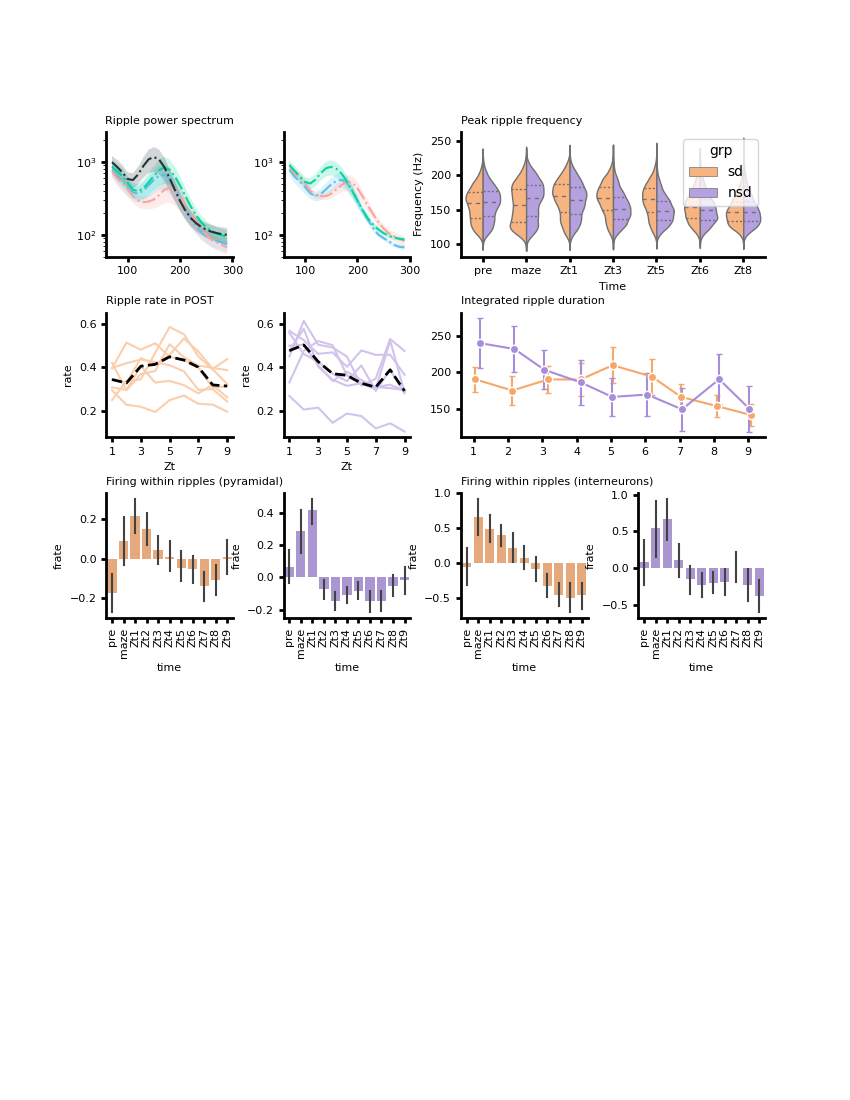

In [52]:
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats

figure = Fig()
fig, gs = figure.draw(grid=(5, 4), hspace=0.45,wspace=0.4)
# psd_colors = ["#BDBDBD", "#EA80FC", "#FF8A80", "#00B8D4"]
psd_colors = [subjects.sd.color(1), subjects.nsd.color(1)]
markers = [[".", ",", "^", "x"], [".", ",", "^"]]
psd_epochs = [["pre", "maze", "sd", "rs"], ["pre", "maze", "post"]]

gs_ = figure.subplot2grid(gs[0, :2], grid=(1, 5), wspace=0)
psd_ = psd[(psd["freq"] > 60) & (psd["freq"] < 300)]
psd_ = psd_.groupby("grp")
for i, (grp, ep, col, marker) in enumerate(
    zip(["sd", "nsd"], psd_epochs, psd_colors, markers)
):
    e_psd = psd_.get_group(grp).groupby("Epoch")
    ax = plt.subplot(gs[i])
    for e, epoch in enumerate(ep):
        mean = e_psd.get_group(epoch).groupby("freq").mean()
        sem = e_psd.get_group(epoch).groupby("freq").sem(ddof=0).psd
        f = mean.index
        ax.plot(f, mean.psd, "-.")
        # ax.scatter(f,mean.psd,marker=marker[e],s=10,alpha=0.6,linewidths=0.5,edgecolors='w')
        ax.fill_between(f, mean.psd - sem, mean.psd + sem, alpha=0.2, ec=None)
        ax.set_yscale("log")
        # ax.set_yscale('log')
        # ax.set_ylim([40,400])
        ax.set_ylim([50, 2600])

        if i==0:
            ax.set_title('Ripple power spectrum')
        # ax.invert_yaxis()

# #---- seaborn power spectrum --------
# for i, grp in enumerate(["sd", "nsd"]):
#     df = psd[psd["grp"] == grp]
#     df = df[(df['freq']>60)&(df['freq']<300)]
#     ax = plt.subplot(gs[i])
#     sns.lineplot(
#         data=df,
#         x="freq",
#         y="psd",
#         hue="Epoch",
#         ci=68,
#         ax=ax,
#         legend=None,
#         # palette=psd_colors,
#     )
#     ax.set_yscale("log")
#     # ax.set_xlim([60, 300])
#     ax.set_ylim([50,3000])
#     ax.set_xlabel("Frequency (Hz)")
#     ax.set_ylabel("Psd")
#     if i==0:
#         ax.set_title('Ripple power spectrum',loc='left')


colors = [subjects.sd.color(1.6), subjects.nsd.color(1.6)]
ax = plt.subplot(gs[0, 2:])
v = sns.violinplot(
    data=peak_freq,
    x="t",
    y="f",
    hue="grp",
    palette=colors,
    legend=None,
    marker="o",
    split=True,
    inner="quartile",
    linewidth=1,
    saturation=1,
    ax=ax,
)
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time")
ax.set_title("Peak ripple frequency", loc="left")
# ax.grid(True)

rate_colors = [subjects.sd.color(1.8), subjects.nsd.color(1.8)]
for i, grp in enumerate(["sd", "nsd"]):
    df = rate[rate["grp"] == grp]
    ax = plt.subplot(gs[1, i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        palette=[rate_colors[i]] * 7,
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color="k",
        ls="--",
        ci=None,
        lw=2,
    )
    # ax.set_yscale('log')
    ax.set_ylim([0.08, 0.65])
    ax.set_xticks(np.arange(1, 10, 2))

    if i == 0:
        ax.set_title("Ripple rate in POST", loc="left")


dur_colors = [subjects.sd.color(1.5), subjects.nsd.color(1.5)]
ax = plt.subplot(gs[1, 2:])

for i, grp in enumerate(["sd", "nsd"]):
    df = total_dur[total_dur["grp"] == grp]
    mean = df.groupby("Zt").mean()
    sem = df.groupby("Zt").sem(0).rpl_duration
    ax.errorbar(
        mean.index.values.astype('int')+np.random.rand(9)*0.2,
        mean.rpl_duration,
        sem,
        marker="o",
        color=dur_colors[i],
        capsize=2,
        markeredgecolor="w",
        # alpha=0.6,
    )
    # sns.lineplot(
    #     data=total_dur,
    #     x="Zt",
    #     y="rpl_duration",
    #     hue="grp",
    #     legend=False,
    #     palette=dur_colors,
    #     marker="o",
    #     ax=ax,
    #     ci="sd",
    #     # ls="--",
    # )
ax.set_title('Integrated ripple duration',loc='left')
# sns.barplot(data=total_dur,x='Zt',y='rpl_duration',hue='grp',ax=ax)

frate_colors = [subjects.sd.color(1.5), subjects.nsd.color(1.5)]

for i, grp in enumerate(["sd", "nsd"]):
    df =frate_rpl_pyr[frate_rpl_pyr["grp"] == grp]
    mean = df.groupby("time").mean()
    sem = df.groupby("time").sem(0).frate
    ax = plt.subplot(gs[2, i])
    # ax.bar(mean.index,mean.frate,color)
    sns.barplot(
        data=df,
        x="time",
        y="frate",
        # hue="grp",
        # legend=False,
        color=frate_colors[i],
        ax=ax,
        ci=90,
        errwidth=1.5,
        # ls="--",
    )

    # ax.errorbar(
    #     list(mean.index.values),
    #     mean.frate.values,
    #     sem,
    #     marker="o",
    #     color=frate_colors[i],
    #     capsize=2,
    #     markeredgecolor="w",
    #     # alpha=0.6,
    # )
    ax.tick_params('x',labelrotation=90)

    if i==0:
        ax.set_title('Firing within ripples (pyramidal)',loc='left')


for i, grp in enumerate(["sd", "nsd"]):
    df =frate_rpl_inter[frate_rpl_inter["grp"] == grp]
    mean = df.groupby("time").mean()
    sem = df.groupby("time").sem(0).frate
    ax = plt.subplot(gs[2, 2+i])
    # ax.bar(mean.index,mean.frate,color)
    sns.barplot(
        data=df,
        x="time",
        y="frate",
        # hue="grp",
        # legend=False,
        color=frate_colors[i],
        ax=ax,
        ci=90,
        errwidth=1.5,
        # ls="--",
    )

    # ax.errorbar(
    #     list(mean.index.values),
    #     mean.frate.values,
    #     sem,
    #     marker="o",
    #     color=frate_colors[i],
    #     capsize=2,
    #     markeredgecolor="w",
    #     # alpha=0.6,
    # )
    ax.tick_params('x',labelrotation=90)

    if i==0:
        ax.set_title('Firing within ripples (interneurons)',loc='left')



figure.savefig(subjects.figpath_sd / "figure2")
